# Imports
## Explanation of Libraries
*   ```pmlb```: Used for fetching datasets from the Penn Machine Learning Benchmark.
*   ```pandas```: Essential for data manipulation and analysis.
*   ```anonymeter```: Functions to evaluate synthetic data's privacy risk
*   ```utils```: Custom functions for plotting graphs based on the results of privacy risk evaluations.

In [1]:
import os
import pandas as pd
from pmlb import fetch_data
from anonymeter.evaluators import SinglingOutEvaluator
from utils import SinglingOutPlots

# Download Data and Split into Original and Control Set

The data used is the Adult Census Income which we will fecth by importing the pmlb library (a wrapper for the Penn Machine Learning Benchmark data repository).

In [2]:
df = fetch_data("adult")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,7,77516.0,9,13.0,4,1,1,4,1,2174.0,0.0,40.0,39,1
1,50.0,6,83311.0,9,13.0,2,4,0,4,1,0.0,0.0,13.0,39,1
2,38.0,4,215646.0,11,9.0,0,6,1,4,1,0.0,0.0,40.0,39,1
3,53.0,4,234721.0,1,7.0,2,6,0,2,1,0.0,0.0,40.0,39,1
4,28.0,4,338409.0,9,13.0,2,10,5,2,0,0.0,0.0,40.0,5,1


In [3]:
num_cols = [
    "age", "fnlwgt", "capital-gain",
     "capital-loss", "hours-per-week"
]
cat_cols = [
    "workclass", "education", "education-num",
    "marital-status", "occupation", "relationship",
    "race", "sex", "native-country", "target"
]
df[cat_cols] = df[cat_cols].astype("category")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  float64 
 1   workclass       48842 non-null  category
 2   fnlwgt          48842 non-null  float64 
 3   education       48842 non-null  category
 4   education-num   48842 non-null  category
 5   marital-status  48842 non-null  category
 6   occupation      48842 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  float64 
 11  capital-loss    48842 non-null  float64 
 12  hours-per-week  48842 non-null  float64 
 13  native-country  48842 non-null  category
 14  target          48842 non-null  category
dtypes: category(10), float64(5)
memory usage: 2.3 MB


## Split Data Set

Split data frame into **Training** and **Control** sets. The control dataset represents a sample of the original data that is not used to generate the synthetic data.

Control Data Set acts as an unbiased privacy risk evaluation. By comparing synthetic data against this dataset we can gauge if the synthetic data generation method is overfitting, and inadvertently exposes unique details of the original dataset.

Save training data as a CSV file to be used for synthetic data generation in DataMaker.

In [5]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle dataframe with seed for repeatability
split = round(0.7 * len(df)) # split 70% Orginal, 30% Control
df_train = df.iloc[:split,:] 
df_control = df.iloc[split:,:] 

In [8]:
training_data_filepath = os.path.join(os.getcwd(),"..", "data","org_adult_census_data.csv")
df_train.to_csv(training_data_filepath, index =False) # Save data to generate synthetic data

# Generating Synthetic Data

There are many algorithms to generate synthetic data some common ones are:
* Gaussian Mixture Models (GMM)
* Tabular Generative Adversarial Networks (GANs)
* Synthetic Minority Oversampling Technique (SMOTE)

This notebook will not be showing the generation of synthetic data, instead, the generated data is saved as data/generated.csv and loaded into the notebook. It was generated using the SAS Data Maker which uses SMOTE.

A small sample of synthetic data has been provided in this notebook for demonstration purposes.

**When using this notebook for your own evaluation, save your generated data in the data folder as generated.csv**



In [13]:
generated_data_filepath = os.path.join(os.getcwd(),"..", "data","generated.csv")
df_syn = pd.read_csv(generated_data_filepath)
df_syn[cat_cols] = df_syn[cat_cols].astype("category")

In [14]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4000 non-null   int64   
 1   workclass       4000 non-null   category
 2   fnlwgt          4000 non-null   int64   
 3   education       4000 non-null   category
 4   education-num   4000 non-null   category
 5   marital-status  4000 non-null   category
 6   occupation      4000 non-null   category
 7   relationship    4000 non-null   category
 8   race            4000 non-null   category
 9   sex             4000 non-null   category
 10  capital-gain    4000 non-null   int64   
 11  capital-loss    4000 non-null   int64   
 12  hours-per-week  4000 non-null   int64   
 13  native-country  4000 non-null   category
 14  target          4000 non-null   category
dtypes: category(10), int64(5)
memory usage: 200.2 KB


# **Singling Out Attack**


## **What is a Singling Out Attack?**
A singling-out attack refers to a scenario where an attacker uses specific combinations of attribute values to uniquely identify individuals in a dataset. If the synthetic data retains the statistical properties of the original dataset to such an extent that these attributes can uniquely identify a record in the training data, it increases the risk of compromising individual privacy.

### **Mechanism of Singling Out Attacks**
1. **Attribute Matching**: The attacker already knows some information about the target individual (e.g., age, gender, location, or occupation), and they use this prior knowledge to filter the dataset for records matching these attributes.

2. **Unique Identification**: If the dataset allows combinations of attributes to uniquely identify a single individual (e.g., "Age = 35, Gender = Male, City = New York"), the attacker can single out the record corresponding to the target person.

3. **Additional Information Discovery**: After identifying the specific record, the attacker can extract other sensitive information associated with the individual in the dataset. For example:

    *   Financial data (e.g., income, capital gains/losses).
    *   Behavioral patterns (e.g., hours worked per week).
    *   Medical history (e.g., diagnosis or treatment details).
    *   Personal habits or preferences.

### **Mitigation Strategies**
1. **Data Generalization**: Remove or generalize details of highly identifying attributes (e.g., replacing "Exact Age" with "Age Range").

2. **Data Perturbation**: Add noise to numerical data or shuffle categorical attributes to reduce exact matches.

3. **K-Anonymity**: Ensure that each combination of attributes corresponds to at least k individuals, making singling out impossible.

### Links
* [What a hybrid legal-technical analysis teaches us about privacy regulation: the case of singling out](https://www.bu.edu/jostl/files/2021/06/1-Altman.pdf).
* [Towards formalizing the gdpr’s notion of singling out](https://arxiv.org/pdf/1904.06009)

## **Privacy Risk**

### **Algorithm Explanation**
The SinglingOutEvaluator is designed to measure the singling-out risk by analyzing how synthetic data could assist an attacker in identifying records in the original dataset. The algorithm operates as follows:

#### **1. Predicate Generation**

**Synthetic Data-Based Predicates**

Predicates (aka queries in this package) are one or more logical conditions (e.g., "Age > 30 AND hours-per-week < 20") generated using the statistical properties of the synthetic dataset.

This library has 2 modes of generating predicates:

* Univariate Predicates: Based on individual attributes (e.g., "Gender = Male").
* Multivariate Predicates: Based on combinations of two or more attributes (e.g., "Age > 30 AND City = New York").

The goal is to create conditions that are likely to match specific records in the original dataset.

**Baseline Predicates**

Baseline predicates are randomly generated without considering statistical insights from the data, representing the success rate of purely chance-based identification efforts. For instance, a predicate like "Age > 25" might be chosen arbitrarily, regardless of its relevance to isolating records. 

These serve as a control to assess the effectiveness of synthetic data-based predicates. If the synthetic predicates outperform the baseline, it indicates that the synthetic data retains meaningful statistical information. By comparing these, evaluators can measure the additional singling-out risk introduced.

#### **2. Validation Against Datasets**

**The generated predicates from synthetic data are tested against:**

* Original Dataset: To check if the predicates can uniquely identify a single record in the original data.
* Control Dataset: A dataset that is not used to generate the synthetic data to act as a comparison.

**The randomly generated predicates are tested against:**

* Original Dataset: To simulate a random attack without any information from the synthetic data

#### **3. Baseline Comparison**

The success rate of predicates derived from the synthetic data is compared to a baseline success rate, to determine the added risks of re-identifaction using the statistical properties of the synthetic data. If the predicates generated from synthetic data are more successful at identifying records in the original dataset compared to the baseline, it indicates an increase in singling out risk.

*The interpretation of the results can be found below.*

In [9]:
columns_to_assess = [
    "age", "fnlwgt","hours-per-week", "workclass",
    "education", "education-num", "marital-status",
    "occupation", "relationship", "race", 
    "sex", "native-country"
    ]
    
# The column to assess are based on prior knowledge of the features, 
# might want to shrink the number of columns to search to reduce evaluation time, 
# or if some columns are not realistic for attackers to obtain.
# For this example we will we will use these for demonstration purposes

In [10]:
evaluator = SinglingOutEvaluator(
    ori=df_train[columns_to_assess], 
    syn=df_syn[columns_to_assess], 
    control=df_control[columns_to_assess],
    n_cols = 2, # number of columns for in one predicate, this will be ignored if evaluate(mode='univariate')
    n_attacks = 100 # number of predicates to generate.
)

try:
    evaluator.evaluate(mode='multivariate') # mode determines the number of columns to use for predicate. possible values 'univariate' or 'multivariate'
    risk = evaluator.risk(confidence_level=0.95)
    print(risk)

except RuntimeError as e: 
    print(f"Singling out evaluation failed with {e}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Found 53 failed queries out of 100. Check DEBUG messages for more details.


PrivacyRisk(value=0.21864854517326274, ci=(0.0843446293505716, 0.3529524609959539))


### **Interpretation of Results**
Privacy risk measures the additional vulnerability posed by the dataset compared to random guessing or attacks on a control dataset. It accounts for the relative success of the attack, normalized to remove noise or general patterns not specific to the dataset.

The risk estimate is accompanied by a confidence interval (at 95% level by default) which accounts for the finite number of attacks performed.
* **PrivacyRisk** (value=0.219): The central estimate of privacy risk is approximately 0.00219 (or 21.9%).
* **Confidence Interval (CI)**: The range is (0.0843, 0.353), meaning there is a 95% confidence that the true privacy risk lies between 8.43% and 35.3%.

**Evaluating the risk level**:

It depends on the interpretation of privacy risk and acceptability thresholds for singling out risk.

Example: If the organization deems anything under 1% as acceptable.

* The point estimate of privacy risk is extremely high (21.9%), indicating that the synthetic data offers low privacy protection.
* In the worst-case scenario (upper bound of the CI at ~0.925%), the risk can go up to 35.3%, suggesting a high potential for singling out attacks.

## **Queries (Predicates) Summary**

In [11]:
predicates = evaluator.queries() # Returns all the queries (predicates) which were successful in singing out a record.

In [12]:
predicates

['fnlwgt>= 1488189 & relationship==0',
 'age>= 87 & education==6',
 'fnlwgt<= 13714 & sex==0',
 'education==6 & fnlwgt<= 24437',
 'fnlwgt>= 1488189 & sex==1',
 'fnlwgt>= 549416 & occupation==9',
 'education==5 & fnlwgt>= 750941',
 'fnlwgt>= 1488189 & occupation==4',
 'education==2 & fnlwgt<= 21207',
 'fnlwgt>= 1117652 & age<= 23',
 'age>= 53 & fnlwgt>= 816677',
 'relationship==1 & fnlwgt<= 13714',
 'age>= 84 & education==4',
 'education==14 & occupation==11',
 'occupation==5 & fnlwgt<= 20800',
 'fnlwgt>= 1086675 & workclass==5',
 'age>= 77 & fnlwgt>= 403926',
 'fnlwgt>= 481161 & race==3',
 'fnlwgt<= 13008 & age<= 34',
 'age>= 83 & education==3',
 'age<= 26 & fnlwgt<= 18481',
 'workclass==3 & fnlwgt>= 462294',
 'fnlwgt>= 932448 & occupation==14',
 'age>= 86 & relationship==2',
 'relationship==2 & fnlwgt>= 708917',
 'age<= 25 & fnlwgt>= 1141526',
 'fnlwgt>= 403907 & age>= 80',
 'occupation==13 & age<= 17',
 'fnlwgt>= 431197 & age>= 76',
 'education==10 & occupation==5',
 'fnlwgt<= 19763 

Custom class function written to visualize predicates generated

In [13]:
singout_predicate_plots = SinglingOutPlots(
    predicates = predicates,
    columns = columns_to_assess
)

Plot the number of predicated for the different combination of columns

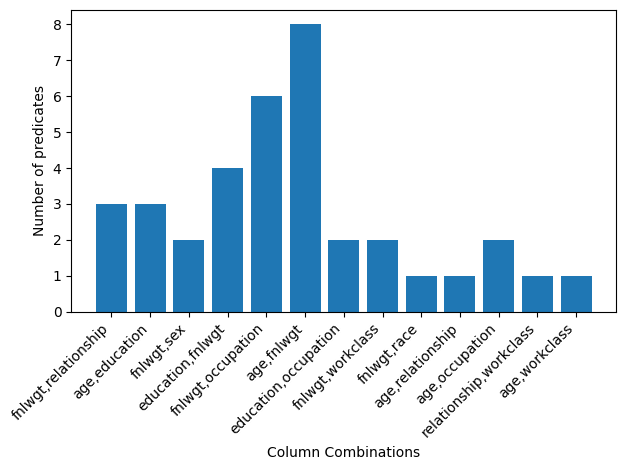

In [14]:
singout_predicate_plots.plot_predicate_column_combi_count(title = '')

Plot the total number of times a column is used to form a predicate

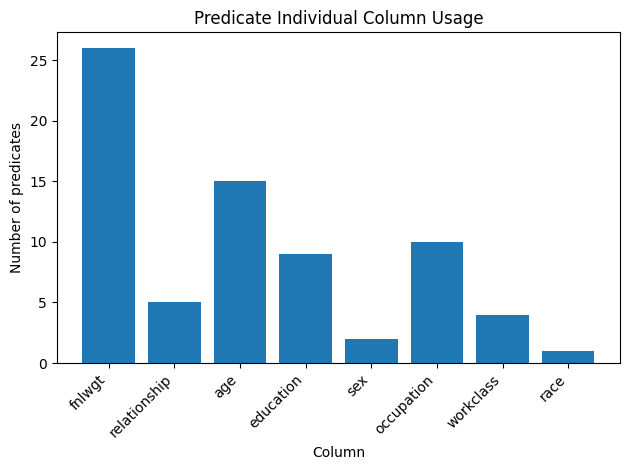

In [18]:
singout_predicate_plots.plot_predicate_column_count(title = '')

We can see all the predicates are using a variable fnlwgt is useful for singling out variables and seems like a potential variable we might want to remove from the dataset.

However, fnlwgt is the Final weight of the record. Interpret it as the number of people represented by this row. Hence it's likely there are many unique values from this row for singling out, but in reality, attackers cannot possibly use this value for reidentification.

This example shows that domain knowledge needs to be applied when doing evaluation as not all columns, like fnlwgt, should be included during the evaluation.

## **Success Rate Interpretation**

In [16]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.365179089748978, error=0.0924668857349347)
Successs rate of baseline attack: SuccessRate(value=0.01849674910349284, error=0.01849674910349284)
Successs rate of control attack: SuccessRate(value=0.18753474338664675, error=0.07414704332506317)


**Low Singling Out Risk:**

If the success rate of predicates derived from the synthetic data is close to or lower than the baseline, the synthetic dataset effectively protects privacy. It suggests that the synthetic data does not disproportionately retain attributes that could be used for identification.


**High Singling Out Risk:**

If the success rate significantly exceeds the baseline, it indicates that the synthetic data retains too much statistical similarity to the original data. This poses a risk of singling out individuals, compromising their privacy.

**Control Data Set Comparison:**

The control attack's success rate is close to the main attack suggesting the method for synthetic data generation may generalize well.

**Thresholds for Acceptability:**

Organizations should define acceptable thresholds for the success rate based on privacy requirements. Results exceeding these thresholds may require further data obfuscation or synthetic data generation techniques to enhance privacy.

**Success Rate Calculation**

The success rate represents the proportion of successful attacks relative to the total attacks. Each success rate (main, baseline, control) shows:
* Point Estimate: The proportion of successes.
* Error Bound: The confidence interval for this estimate.

**Example**

Value: approximately 36.5%
* Represents the proportion of successful attacks relative to total attacks.
* Indicates the success rate of the primary attack on the dataset.

Error: approximately 9.25%
* Confidence interval half-width, meaning the actual success rate lies within 36.5%±9.25% (with 95% confidence).

# **Anonymter Citation**

In [ ]:
'''
@misc{anonymeter,
  doi = {https://doi.org/10.56553/popets-2023-0055},
  url = {https://petsymposium.org/popets/2023/popets-2023-0055.php},
  journal = {Proceedings of Privacy Enhancing Technologies Symposium},
  year = {2023},
  author = {Giomi, Matteo and Boenisch, Franziska and Wehmeyer, Christoph and Tasnádi, Borbála},
  title = {A Unified Framework for Quantifying Privacy Risk in Synthetic Data},
}
'''